# Paqueterías

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'lightgrey'

# Funciones

In [2]:
def get_financials(ticker:str) -> pd.DataFrame:
    bs = yf.Ticker(ticker).balance_sheet.iloc[:, :-1]
    ist = yf.Ticker(ticker).income_stmt.iloc[:, :-1]
    cf = yf.Ticker(ticker).cash_flow.iloc[:, :-1]
    return bs, ist, cf

# Bajar un precio en una fecha dada
def get_historical_price(ticker: str, start: str):
    end = start+datetime.timedelta(days=4)
    price=pd.DataFrame(yf.Ticker(ticker).history(start=start, end=end)["Close"])
    return price.iloc[0, 0]

def volatility(ticker:str) -> float:
    return (yf.download(ticker, start='2021-01-01', progress=False)['Close'].pct_change().dropna().std() * np.sqrt(252)).values[0]

def expected_return(ticker:str) -> float:
    return (yf.download(ticker, start='2021-01-01', progress=False)['Close'].pct_change().dropna().mean() * 252).values[0]

def plot_financials(ticker: str):
    # Fetch financial data
    bs, ist, cf = get_financials(ticker)

    # Calculate financial ratios
    gross_margin = ist.loc['Gross Profit'] / ist.loc['Total Revenue']
    operating_margin = ist.loc['Operating Income'] / ist.loc['Total Revenue']
    net_margin = ist.loc['Net Income Common Stockholders'] / ist.loc['Total Revenue']
    roe = ist.loc['Net Income Common Stockholders'] / bs.loc['Total Capitalization']
    revenue = ist.loc['Total Revenue']
    fcf_to_sales = cf.loc['Free Cash Flow'] / ist.loc['Total Revenue']
    current_ratio = bs.loc['Current Assets'] / bs.loc['Current Liabilities']
    solvency = bs.loc['Total Assets'] / bs.loc['Total Liabilities Net Minority Interest']
    eps = ist.loc['Net Income Including Noncontrolling Interests'] / bs.loc['Common Stock Equity']
    per = [get_historical_price(ticker, date) for date in bs.columns] / eps
    pbv = bs.loc['Common Stock Equity'] * [get_historical_price(ticker, date) for date in bs.columns] / bs.loc['Total Capitalization']

    df_multiplos = pd.DataFrame({
        'Gross Margin': gross_margin,
        'Operating Margin': operating_margin,
        'Net Margin': net_margin,
        'ROE': roe,
        'Revenue': revenue,
        'FCF to Sales': fcf_to_sales,
        'Current Ratio': current_ratio,
        'Solvency': solvency,
        'EPS': eps,
        'PER': per,
        'PBV': pbv,
        'Price': [get_historical_price(ticker, date) for date in bs.columns]
    }).sort_index()

    # Fetch stock price data (last 4 years)
    stock_data = yf.download(ticker, period='4y', progress=False)['Close']
    
    # Create figure with subplots: 3 rows (financials) + 1 row (stock price)
    fig = plt.figure(figsize=(20, 18))
    gs = fig.add_gridspec(4, 1, height_ratios=[1, 1, 1, 1.5])  # 3 rows for financials, 1 row for stock price
    
    # Main title
    fig.suptitle(ticker, fontsize=24, fontweight='bold', y=0.98)
    
    # --- Financial Ratios (3x4 grid) ---
    # Create 3x4 grid for financial metrics
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[2, 0])
    
    # Split financial metrics into 3 groups for each row
    metrics = [
        ['Gross Margin', 'Operating Margin', 'Net Margin', 'ROE'],
        ['Revenue', 'FCF to Sales', 'Current Ratio', 'Solvency'],
        ['EPS', 'PER', 'PBV', 'Price']
    ]
    
    # Plot financial metrics
    for row_idx, row_axes in enumerate([ax1, ax2, ax3]):
        # Create 4 subplots within this row
        row_axes.remove()  # Remove the original axis
        sub_gs = gs[row_idx, 0].subgridspec(1, 4, wspace=0.3)
        row_axes = [fig.add_subplot(sub_gs[0, i]) for i in range(4)]
        
        for i, metric in enumerate(metrics[row_idx]):
            row_axes[i].plot(df_multiplos.index, df_multiplos[metric], c='navy', marker='o')
            row_axes[i].set_title(metric, fontsize=14, fontweight='bold')
            x_ticks = np.linspace(0, len(df_multiplos.index)-1, 4, dtype=int)
            row_axes[i].set_xticks(df_multiplos.index[x_ticks])
            row_axes[i].tick_params(axis='x', rotation=0)
            row_axes[i].grid(True, ls='--', alpha=0.4)

    # --- Stock Price Plot (Bottom Row) ---
    mu = expected_return(ticker)
    sigma = volatility(ticker)
    ax_stock = fig.add_subplot(gs[3, 0])
    ax_stock.plot(stock_data.index, stock_data, c='navy', linewidth=2)
    ax_stock.set_title(rf'{ticker} Stock Price (Last 4 Years) $\rightarrow \mu =${mu:.2%} $\sigma=${sigma:.2%}', fontsize=14, fontweight='bold')
    ax_stock.grid(True, ls='--', alpha=0.4)
    
    plt.tight_layout()
    plt.show()

# Salud

YF.download() has changed argument auto_adjust default to True


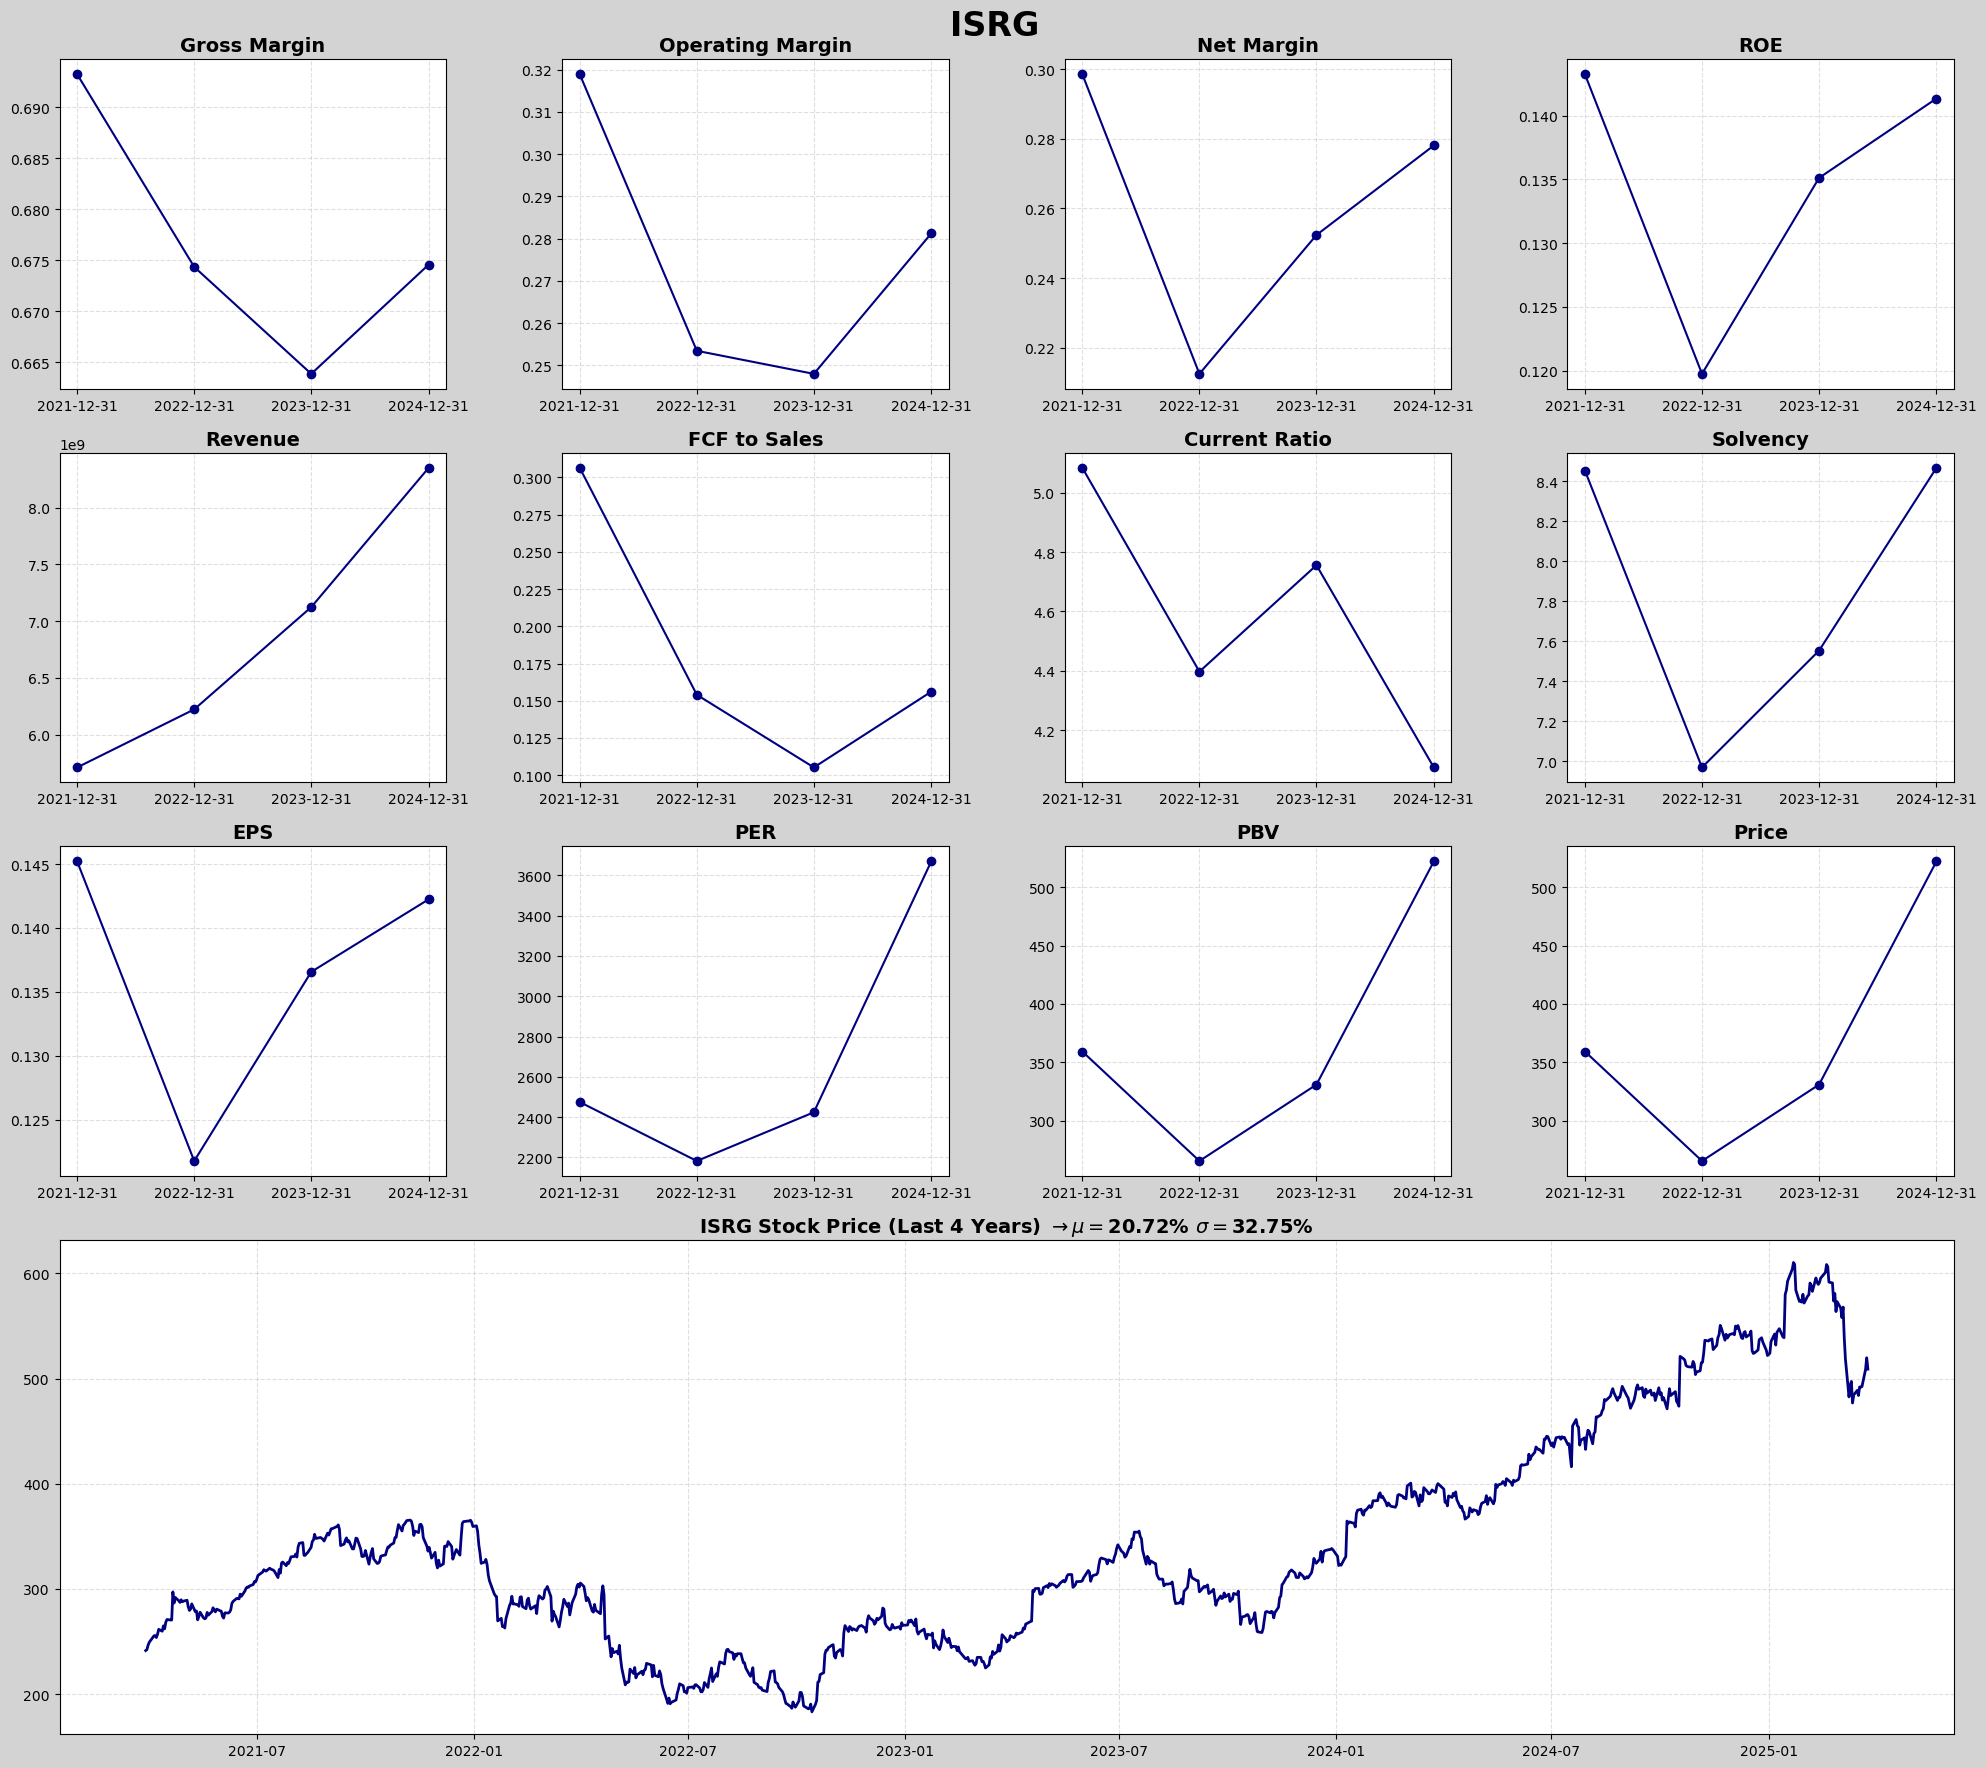

In [3]:
healthcare = ["ISRG"]
for i in range(len(healthcare)):
    plot_financials(healthcare[i])

# Bienes escenciales

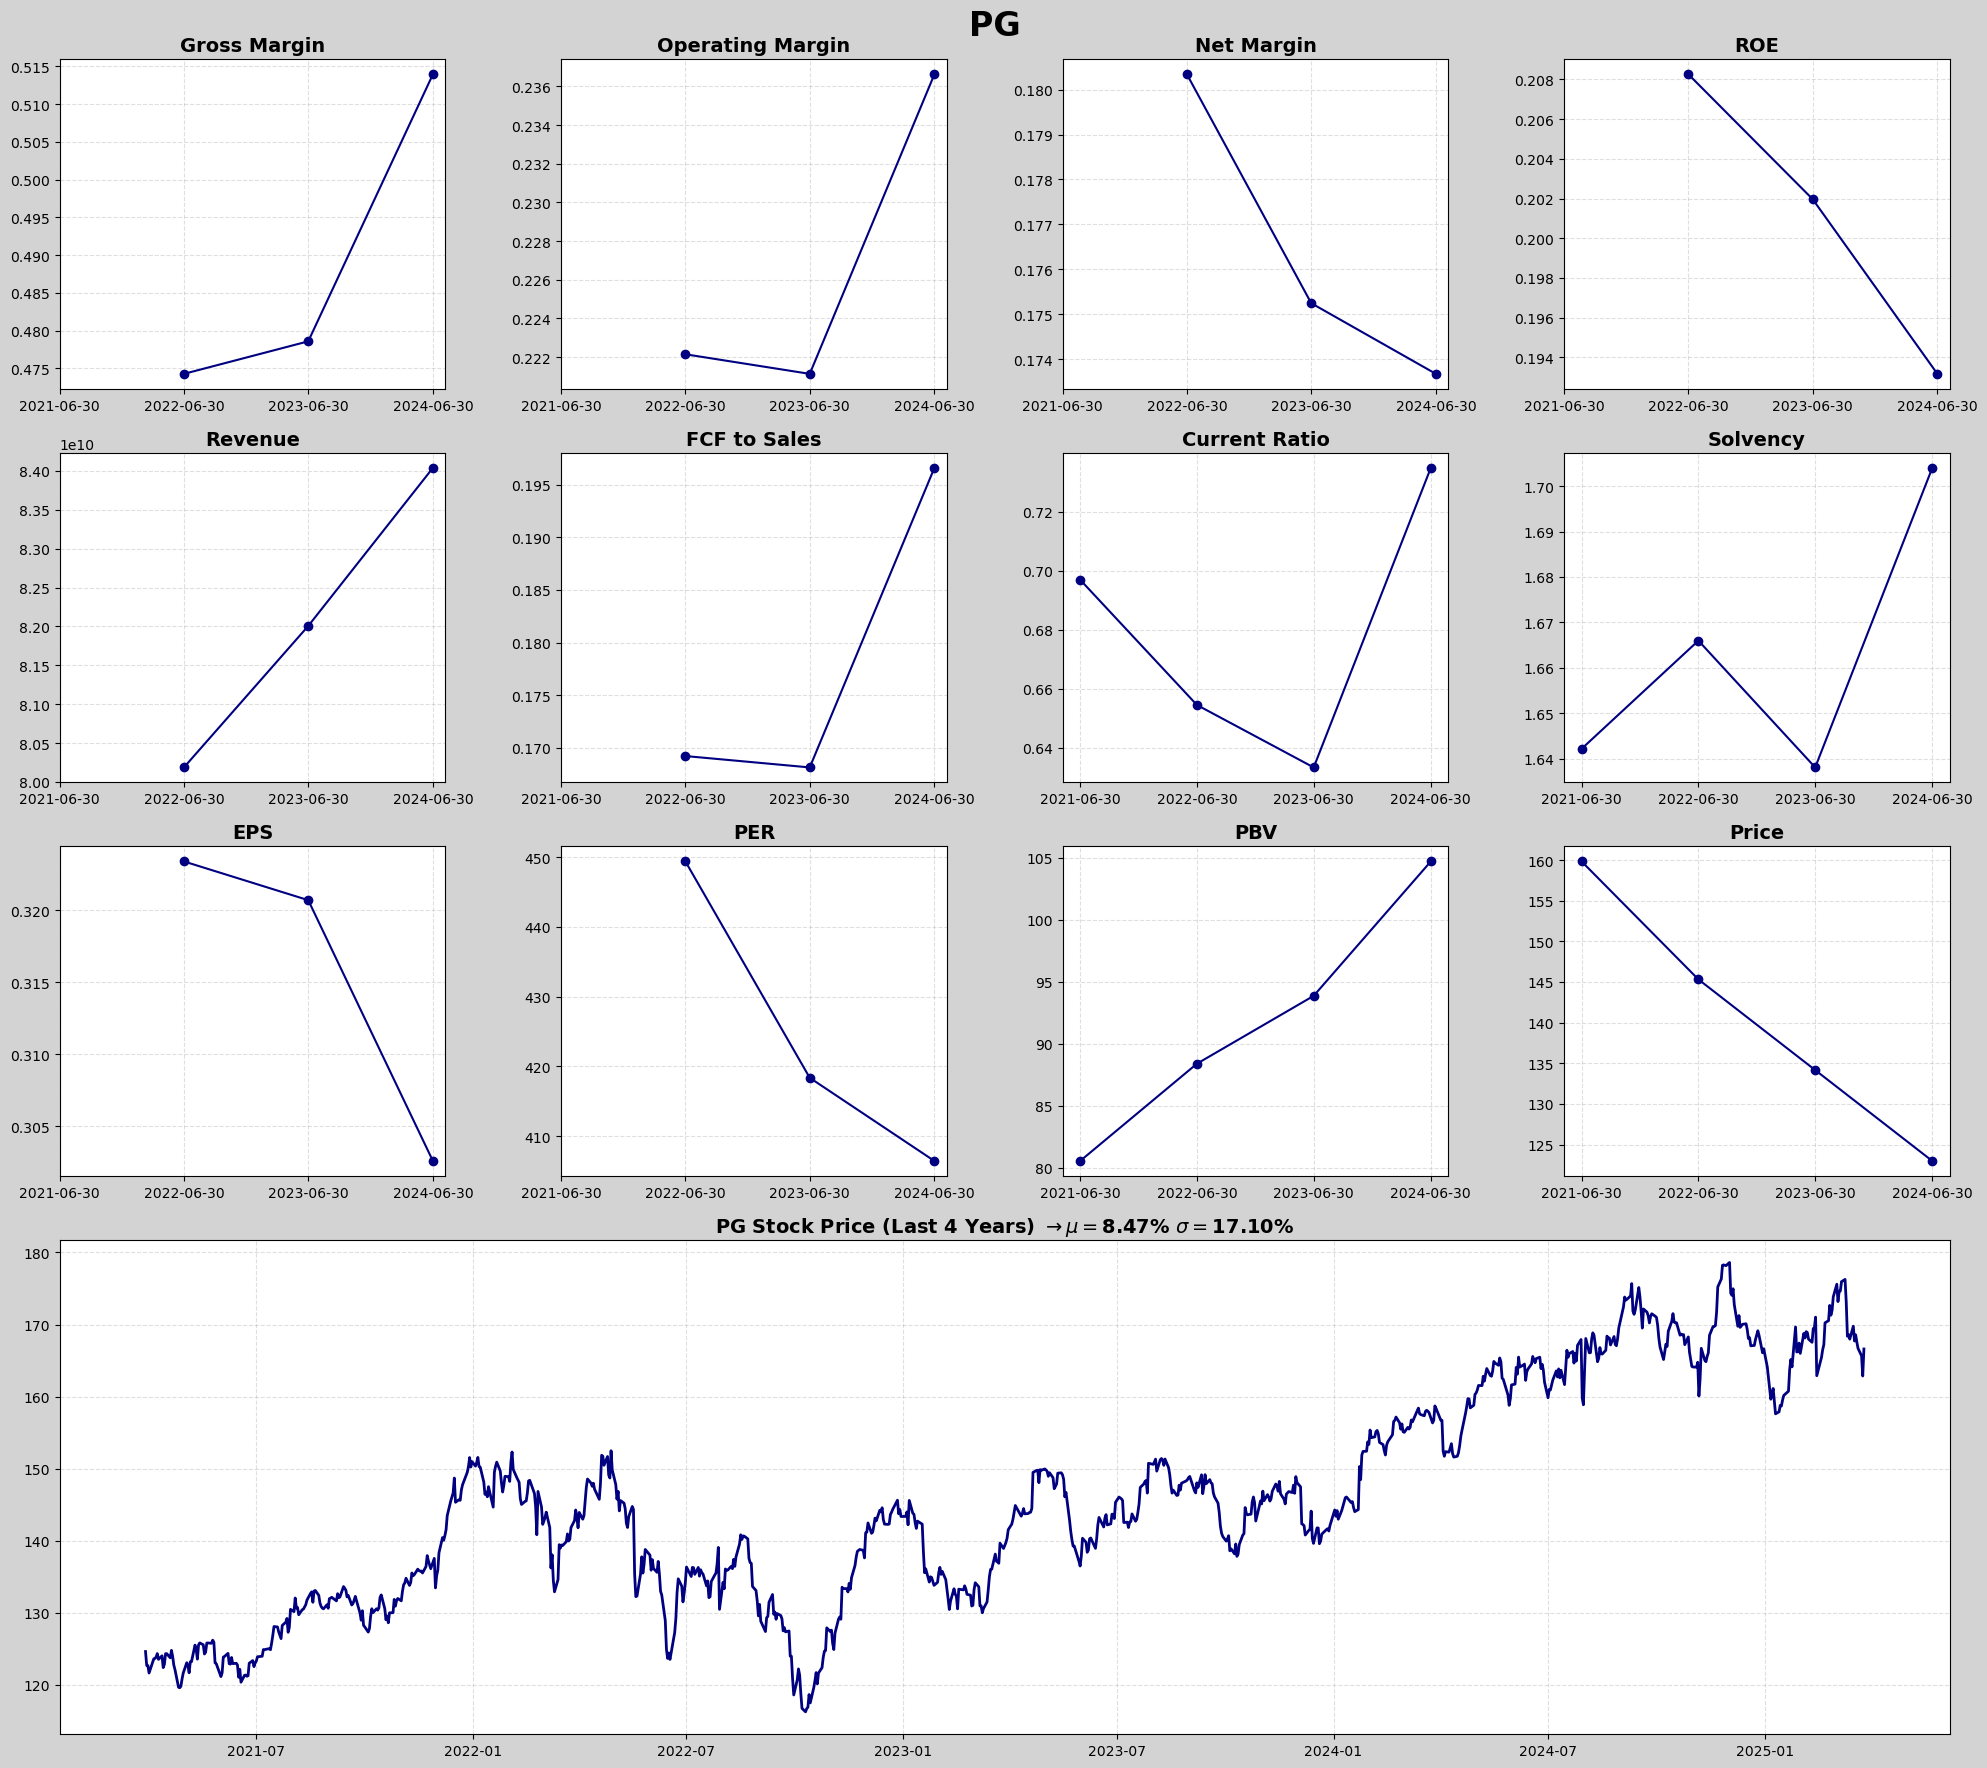

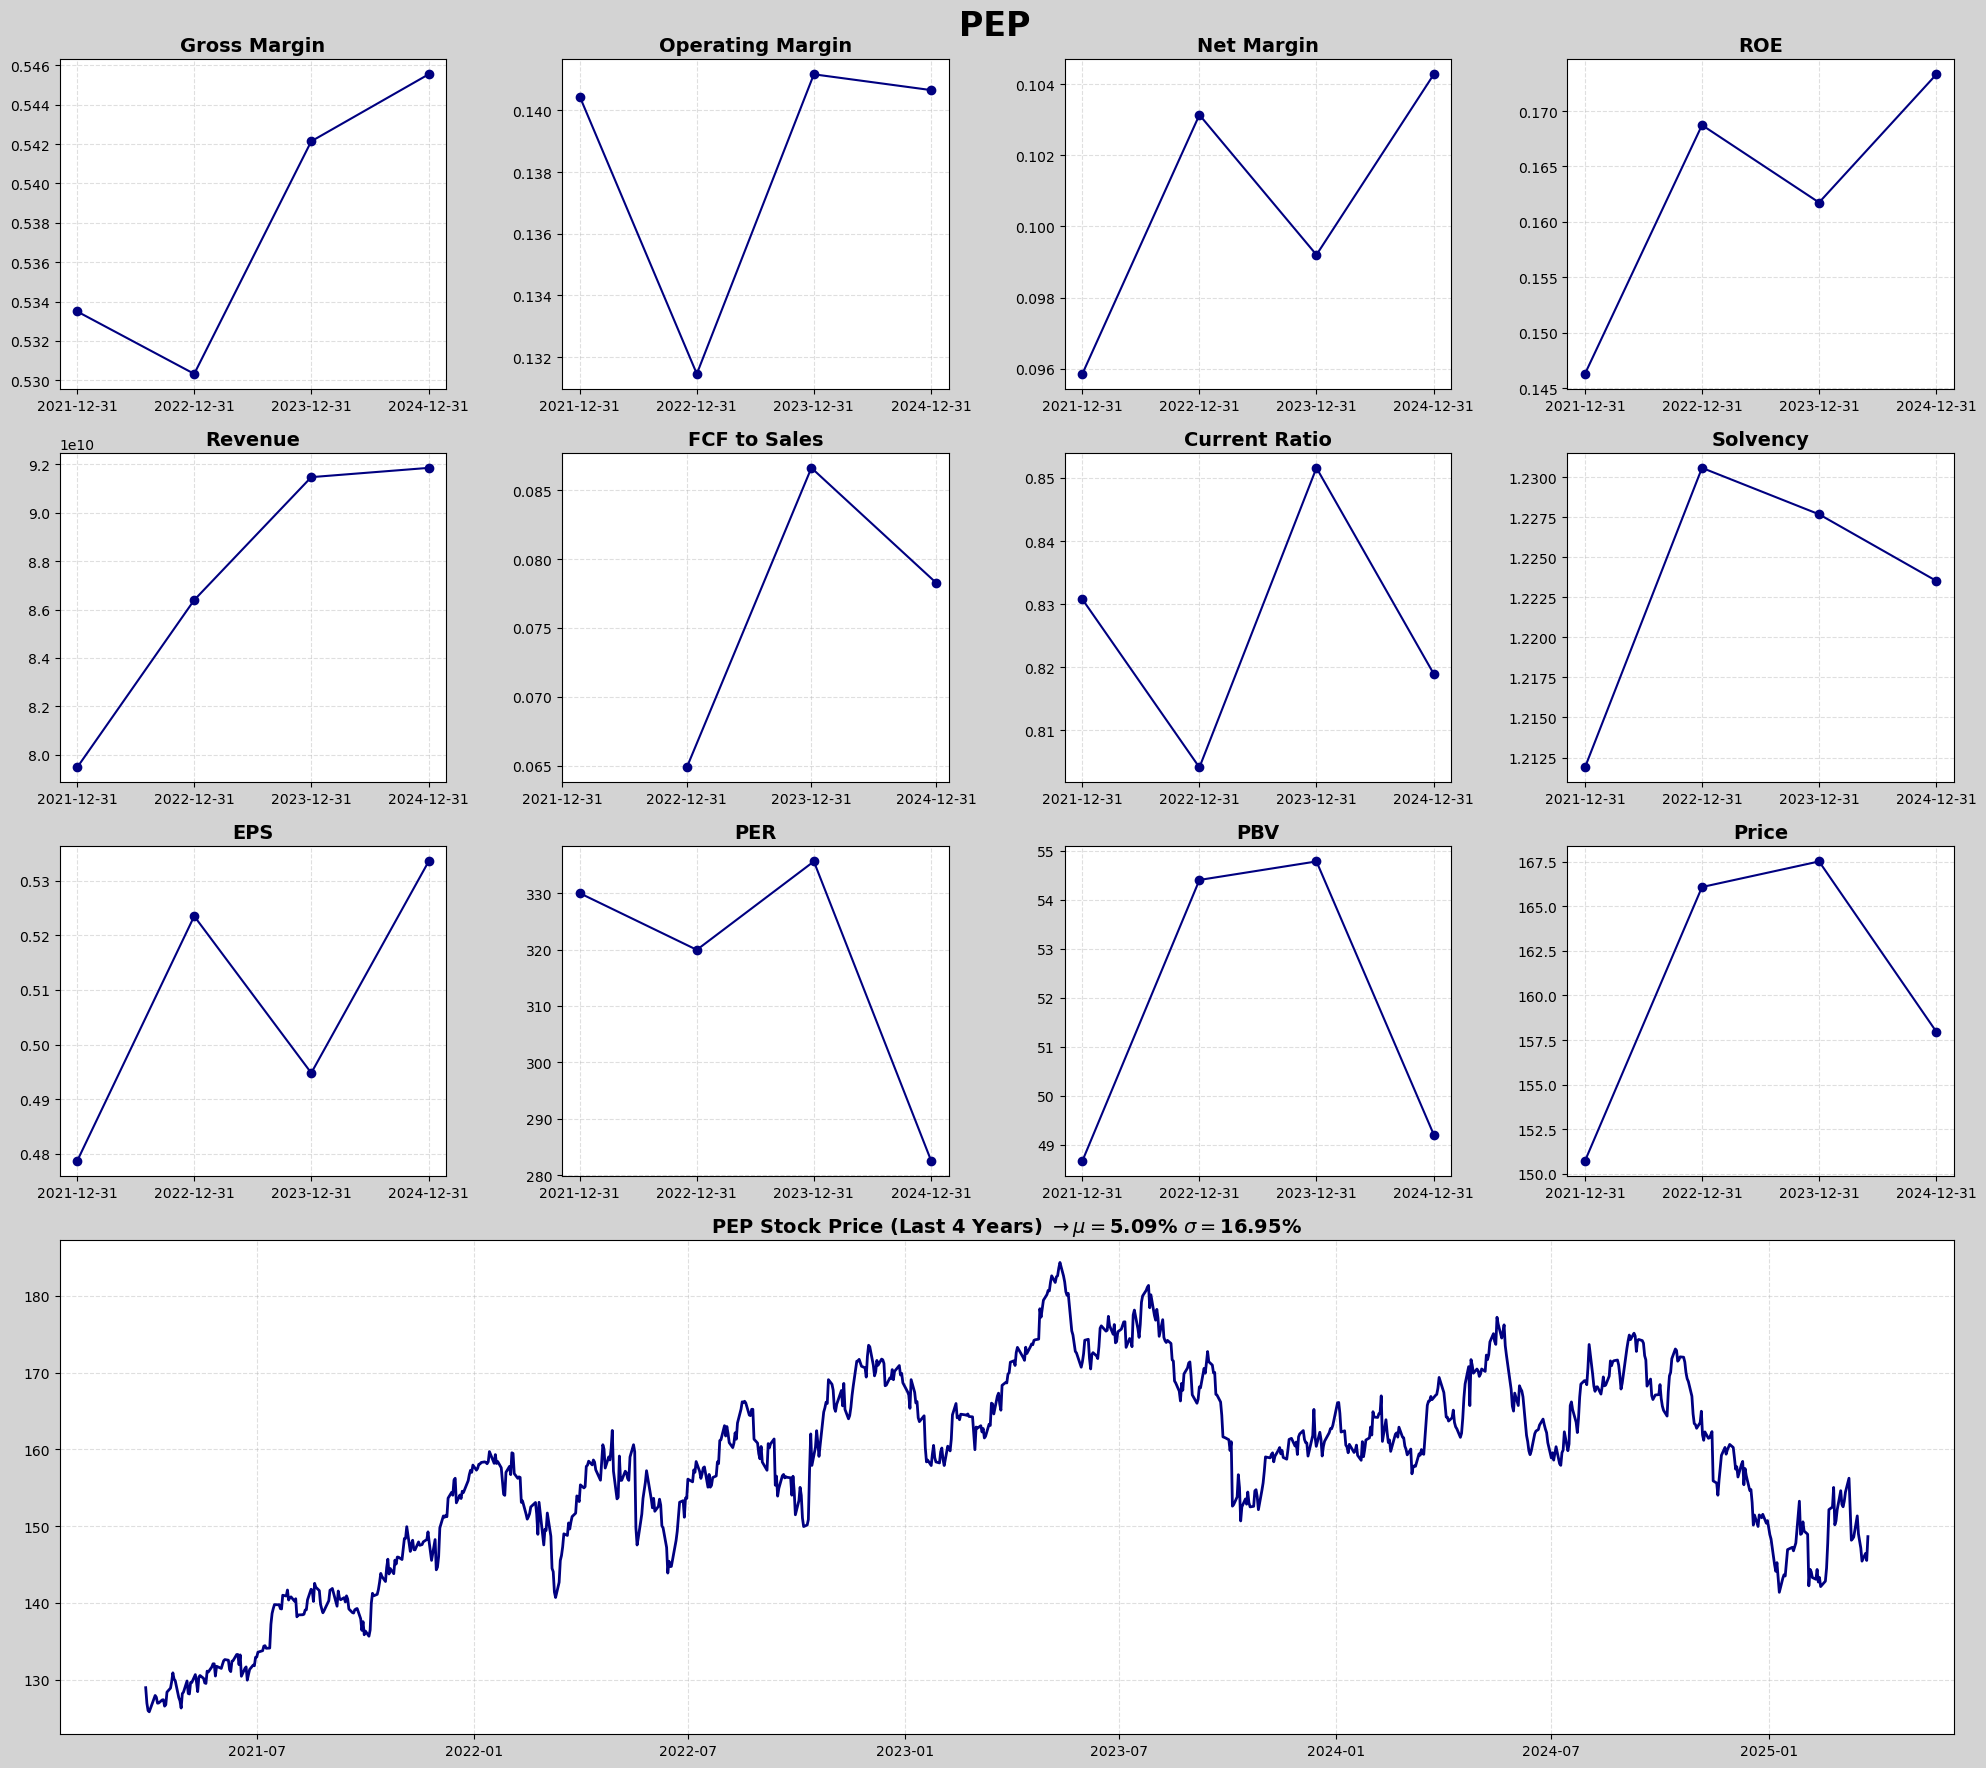

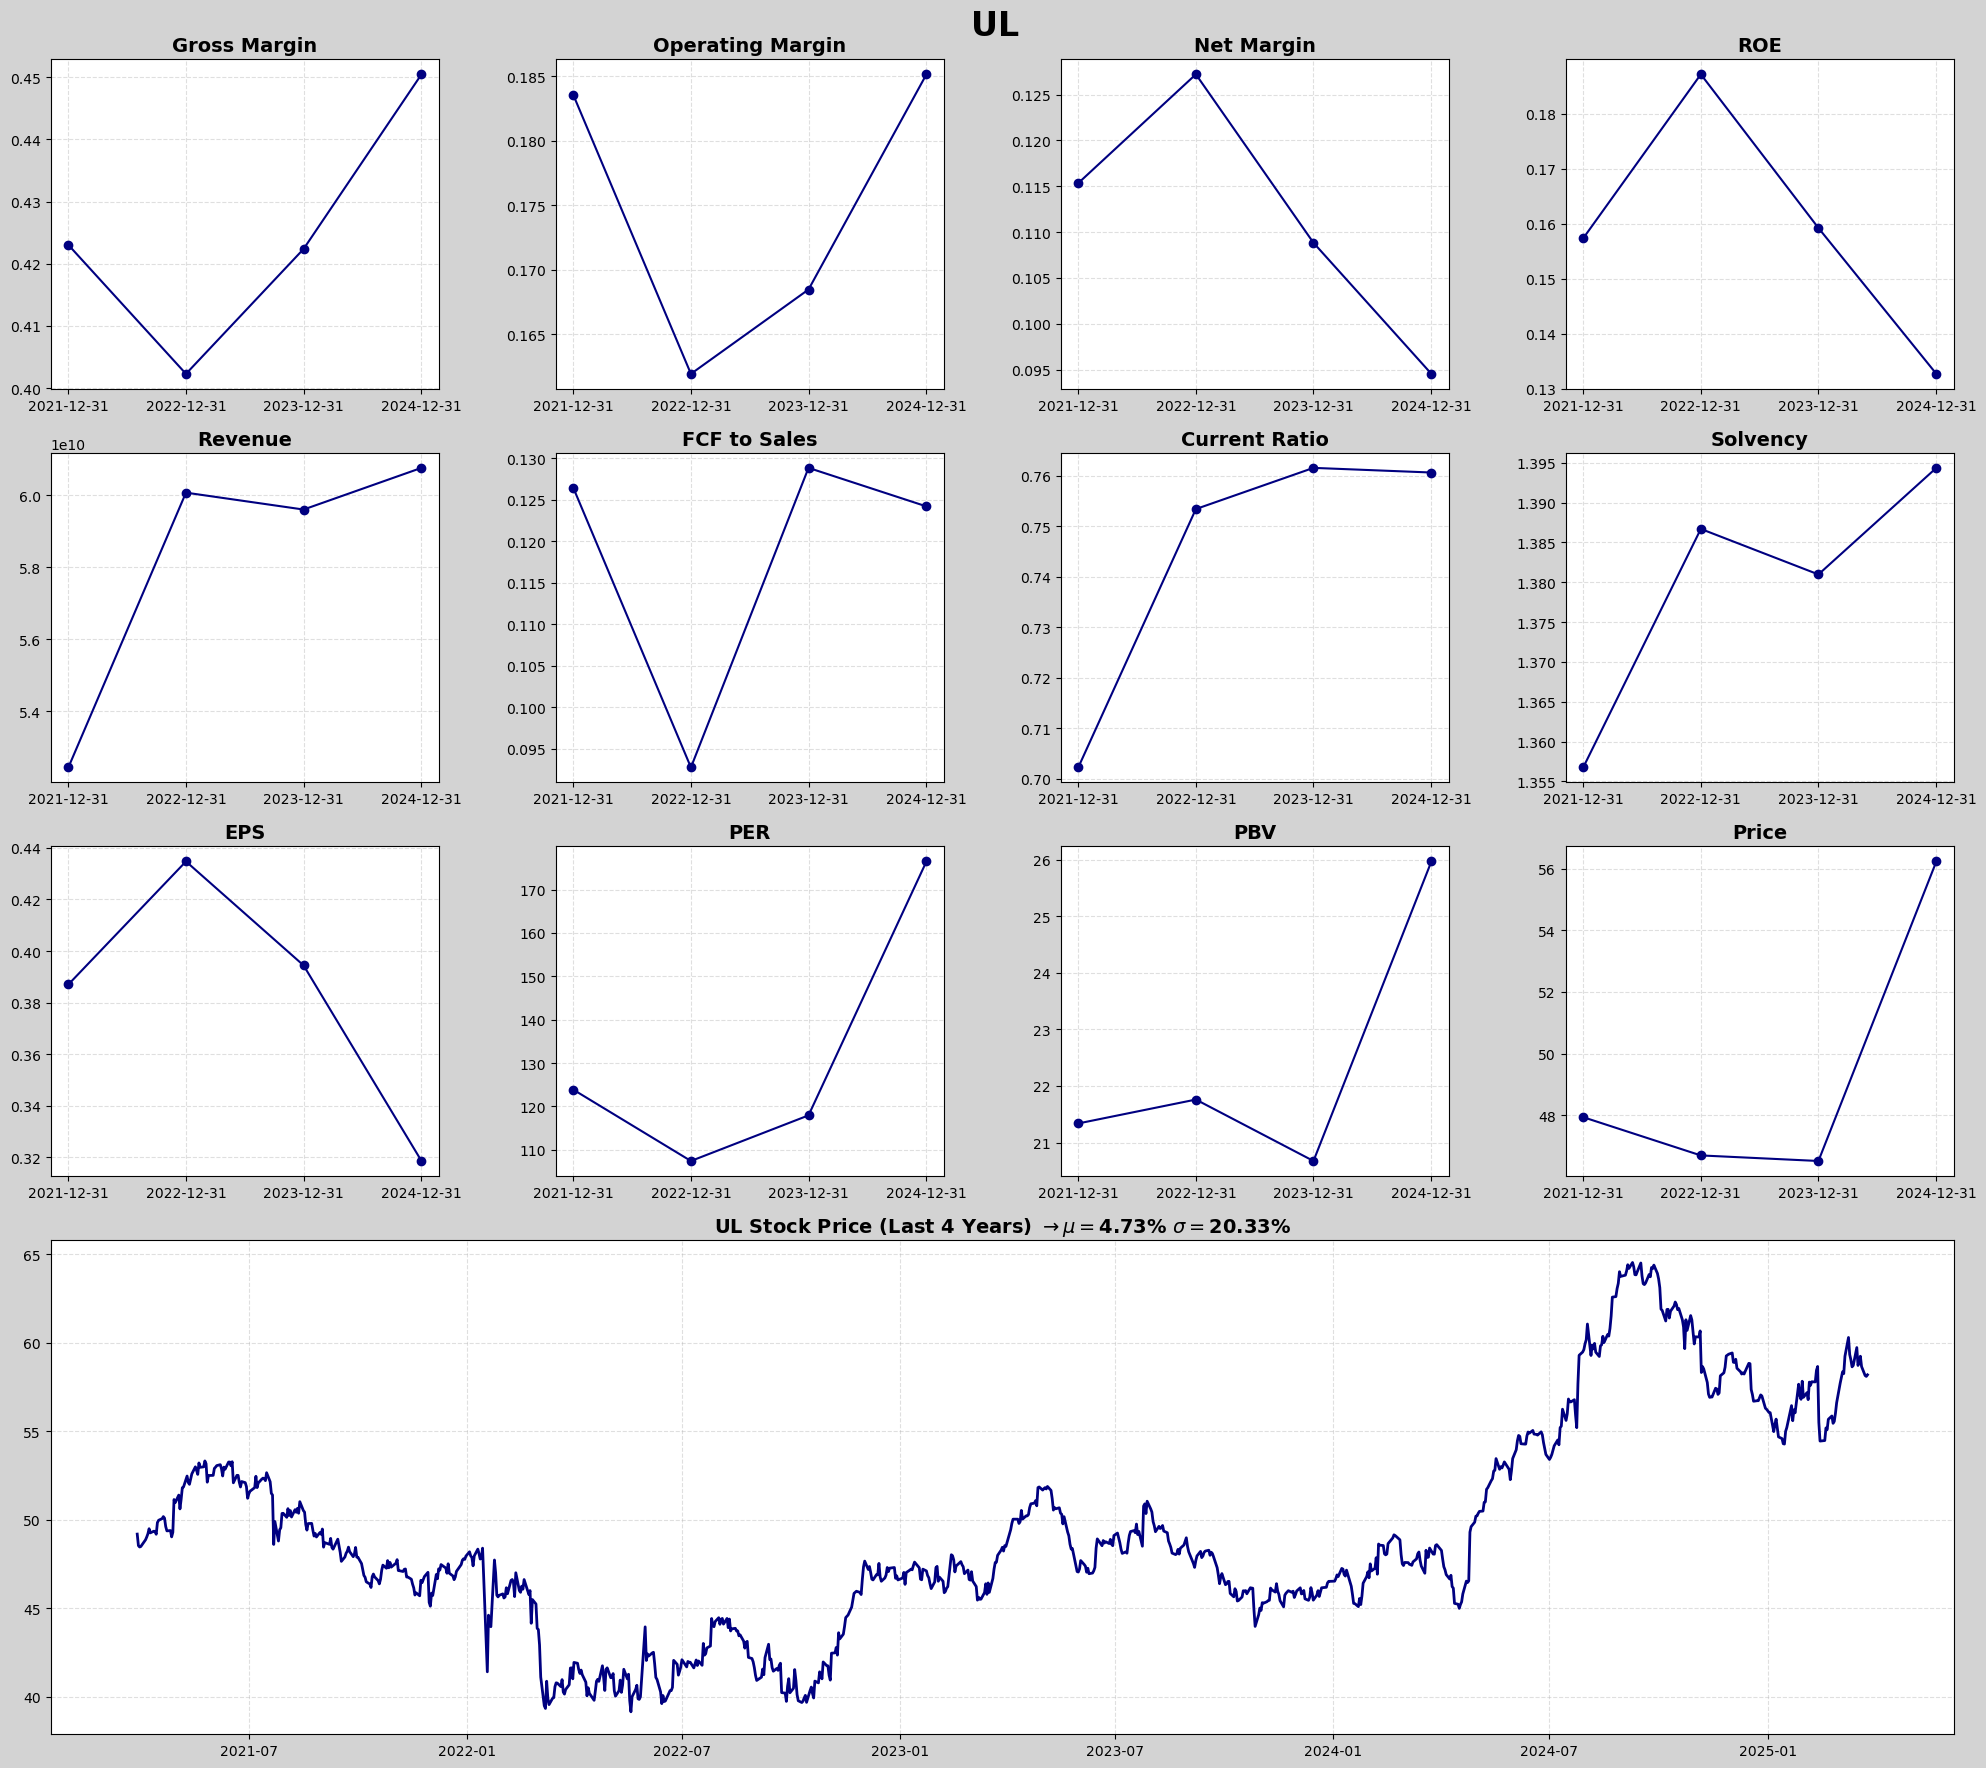

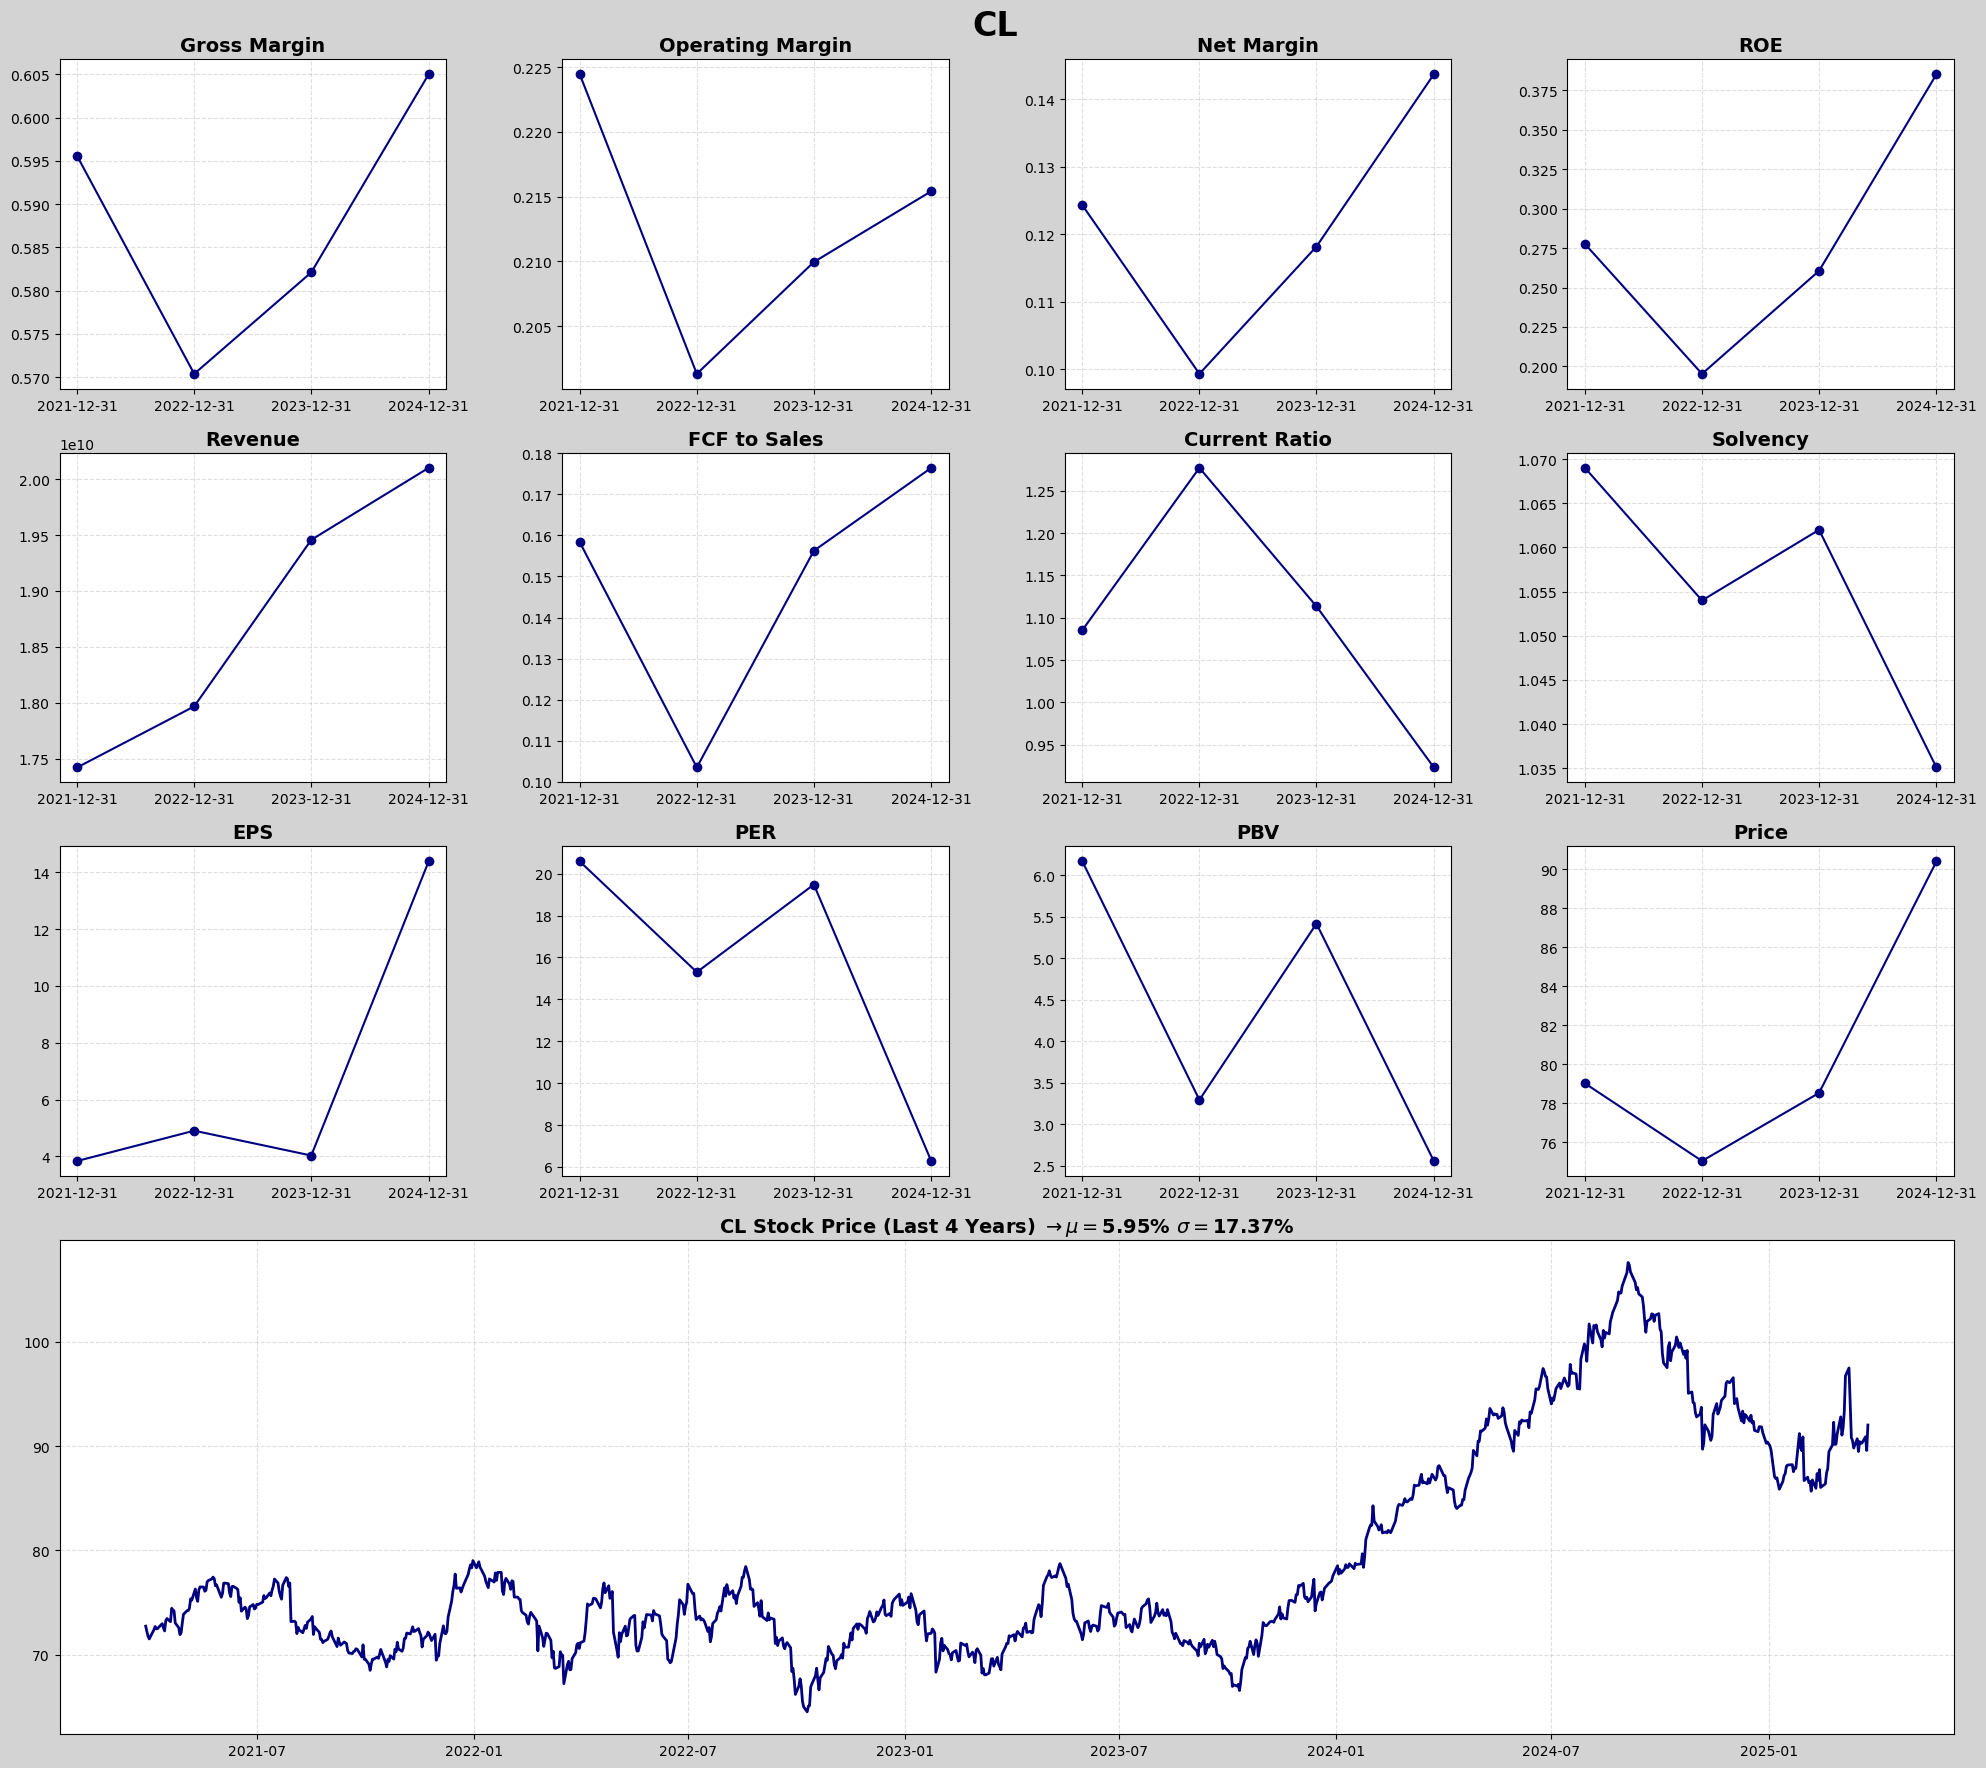

In [4]:
consumer_staples = ["PG", "PEP", "UL", "CL"]
for i in range(len(consumer_staples)):
    plot_financials(consumer_staples[i])